In [37]:

import importlib.util
import matplotlib.animation as animation
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.constants import c
from IPython.display import display, Math
from functools import partial
import seaborn as sns

from pydantic import validate_call

import gdsfactory as gf

In [2]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math

In [4]:
lumapiFile = r"C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
spec = importlib.util.spec_from_file_location("lumapi", lumapiFile)
lumapi = importlib.util.module_from_spec(spec)
spec.loader.exec_module(lumapi)
ict_api = lumapi.INTERCONNECT(hide = False)

C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py:796: SyntaxWarning: invalid escape sequence '\s'
  message = re.sub('^(Error:)\s(prompt line)\s[0-9]+:', '', str(rvals[2])).strip()


In [5]:
ict_api.expressioncheckoff()

In [6]:
um = 1e-6
nm = 1e-9

In [8]:
ng_ideal = 4.3458
ng_pdk = 4.19088
neff = 2.3531
neff_pdk = 2.44553
L = 20.3 * um
lambda_0 = 1546.363 * nm
#fsr_ofc = 1.6

power_couplings1 = [0.5, 0.13, 0.12, 0.5]

def delay_length(cascate,horizontal_section,mzi,fsr_ofc,ng,neff):
    
    
    dl_base = (lambda_0**2 / (2*fsr_ofc * nm * ng))*(2**(cascate-3))
    dl_pi = (lambda_0 / neff)
    
    match horizontal_section*(cascate**2):
        case 0: shift = 0
        case 1: shift = 0.25
        case 2: shift = 0.125
        case 3: shift = 0.375
        case 4: shift = 0.75

    Delay_Length=dl_base+(dl_pi*shift)
    
    match mzi:
        case 0: dl = Delay_Length
        case 1: dl = 2*Delay_Length
        case 2: dl = 2*Delay_Length+dl_pi
    
    return(dl)


# Ideal MZI simulation

In [9]:
'''
fsr é o valor em nm do fsr
ORDEM é a ordem do filtro usado na cascada (vai de 1 a 3), o número depois se refere a ordem de cada filtro individualmente
cascade é a quantidade de filtros usados naquele nivel podendo ser 1, 2 ou 4
type é se é ideal ou pdk
'''
def MZI_filter(fsr,ORDEMA,ORDEMB,ORDEMC,ORDEMD,cascade,type):
    
    X = {0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 2, 6: 2}
    Y = {0: 0, 1: -1, 2: 1, 3: -2, 4: -1, 5: 1, 6: 2}
    if (type == "ideal"):
        Coupler = "Waveguide Coupler"
        Straight_Waveguide = "Straight waveguide"
        ng = 4.3458
        neff = 2.3531
        lenght_name = 'length'
        port = 'port '
    if (type == 'pdk'):
        Coupler = "ebeam_dc_te1550"
        Straight_Waveguide = 'ebeam_wg_integral_1550'
        ng = 4.19088
        neff = 2.44553
        lenght_name = 'wg_length'
        port = 'opt_'
    

    
    for n in range (cascade):
        if (cascade==1):
            level='A'
            final_conection1 = f"splitterB{2*n}0"
            fc_input1 = f"{port}2"
            final_conection2 = f"splitterB{2*n+1}0"
            fc_input2 = f"{port}1"
        if (cascade==2):
            level='B'
            final_conection1 = f"splitterC{2*n}0"
            fc_input1 = f"{port}2"
            final_conection2 = f"splitterC{2*n+1}0"
            fc_input2 = f"{port}1"
        if (cascade==4):
            level='C' 
            final_conection1 = "ONA"
            fc_input1 = f"input {2*n+1}"
            final_conection2 = f"ONA"
            fc_input2 = f"input {2*n+2}"       
        x= X[n+cascade-1]
        y= Y[n+cascade-1]
        if n==0: ordem=ORDEMA
        if n==1: ordem=ORDEMB
        if n==2: ordem=ORDEMC
        if n==3: ordem=ORDEMD

        for i in range (ordem):
            
            if ordem==1:
                coupling_length = [17.5*um,17.5*um]
                power_couplings = [0.5,0.5]
            if ordem==2:
                coupling_length = [17.5*um,12.5*um,5*um]
                power_couplings = [0.5,0.29,0.08]
            if ordem==3:
                coupling_length = [17.5*um,10*um,10*um,2.5*um]
                power_couplings = [0.5,0.2,0.2,0.04]
            
            ict_api.addelement(Coupler)
            ict_api.set("name",f"splitter{level}{n}{i}")
            if (type=="pdk"):
                ict_api.set("coupling_length",coupling_length[i])
            if (type=="ideal"):
                ict_api.set("coupling coefficient 1",power_couplings[i])
                ict_api.set("coupling coefficient 2",power_couplings[i])
            ict_api.addelement(Straight_Waveguide)
            ict_api.set("name",f"wvg{level}{n}{i}")
            if (type=="ideal"):
                ict_api.set("effective index 1",neff)
                ict_api.set("group index 1",ng)
            ict_api.set(lenght_name,L+delay_length(-(np.log2(cascade)-3),n,i,fsr,ng,neff))
            ict_api.addelement(Straight_Waveguide)
            ict_api.set("name",f"wvg2{level}{n}{i}")
            if (type=="ideal"):
                ict_api.set("effective index 1",neff)
                ict_api.set("group index 1",ng)
            ict_api.set(lenght_name,L)#delay_length(cascate,horizontal_section,mzi,fsr_ofc,,ng)
            
            xs = -1000 +1400*x + (i*400)
            ys = +1500 + y*(1500/4)
            xc=xs+400
            yc=ys
            xw1=xs+200
            yw1=ys-100
            xw2=xw1
            yw2= ys+100 
            ict_api.setposition(f"splitter{level}{n}{i}",xs,ys)
            ict_api.setposition(f"wvg{level}{n}{i}",xw1,yw1)
            ict_api.setposition(f"wvg2{level}{n}{i}",xw2,yw2)
            
            ict_api.connect(f"splitter{level}{n}{i}", f"{port}3", f"wvg{level}{n}{i}", "port 1")
            ict_api.connect(f"splitter{level}{n}{i}", f"{port}4", f"wvg2{level}{n}{i}", "port 1")
            if i>0:
                ict_api.connect(f"wvg{level}{n}{i-1}", "port 2", f"splitter{level}{n}{i}", f"{port}1")
                ict_api.connect(f"wvg2{level}{n}{i-1}", "port 2", f"splitter{level}{n}{i}", f"{port}2")
                ict_api.select(f"wvg{level}{n}{i}")
                ict_api.set(lenght_name,L)
                ict_api.select(f"wvg2{level}{n}{i}")
                ict_api.set(lenght_name,L+delay_length(-(np.log2(cascade)-3),n,i,fsr,ng,neff))
            if i==(ordem-1):
                ict_api.addelement(Coupler)
                ict_api.set("name",f"combiner{level}{n}{i}")
                ict_api.setposition(f"combiner{level}{n}{i}",xc,yc)   
                if (type=="pdk"):
                    ict_api.set("coupling_length",coupling_length[i+1])
                if (type=="ideal"):
                    ict_api.set("coupling coefficient 1",power_couplings[i+1])
                    ict_api.set("coupling coefficient 2",power_couplings[i+1])
                ict_api.connect(f"wvg{level}{n}{i}", "port 2", f"combiner{level}{n}{i}", f"{port}1")
                ict_api.connect(f"wvg2{level}{n}{i}", "port 2", f"combiner{level}{n}{i}", f"{port}2")
                ict_api.connect(f"combiner{level}{n}{i}", f"{port}3",final_conection1, fc_input1)
                ict_api.connect(f"combiner{level}{n}{i}", f"{port}4",final_conection2, fc_input2)


In [10]:
def lattice_filter(fsr,type):
    ict_api.switchtodesign()

    ict_api.deleteall()

    ict_api.addelement("Optical Network Analyzer")
    ict_api.set("name","ONA")
    ict_api.set("number of points",10000)
    ict_api.set("input parameter",2)
    ict_api.set("start frequency",c/(1500*nm))
    ict_api.set("stop frequency",c/(1600*nm))
    ict_api.setposition("ONA",0,0)
    ict_api.set("number of input ports", 8)

    if (type == "ideal"): TE_gain = "TE gain (dB)" ;port = 'port '
    if (type == "pdk"): TE_gain = "'TE' gain (dB)" ;port = 'opt_'
    
    MZI_filter(fsr,2,2,2,2,4,type)
    MZI_filter(fsr,2,2,2,2,2,type)
    MZI_filter(fsr,2,2,2,2,1,type)
            
        
    ict_api.connect("splitterA00", f"{port}2","ONA", "output")
    
    ict_api.switchtodesign()
    ict_api.run()
        
    plt.figure(figsize=(10,6))  # Tamanho do gráfico

    for input in range(8):
        wavelength = ict_api.getresult("ONA", f"input {input+1}/mode 1/gain")['wavelength']
        te_gain_db = ict_api.getresult("ONA", f"input {input+1}/mode 1/gain")[TE_gain]
        plt.plot(wavelength*1e9, te_gain_db, label=f'Input {input+1}')  # X em nm

    # Configurações atualizadas
    plt.xlabel('Wavelength (nm)')
    plt.ylabel(TE_gain)
    plt.title('Lattice Filter - All Inputs')
    plt.grid(True)
    plt.legend()
    plt.xlim(1545, 1555)  # Novo limite X
    plt.ylim(-15,0)    # Novo limite Y
    plt.hlines(-3, 1530, 1565,linestyles="--",)
    plt.show()

## Making the circuit

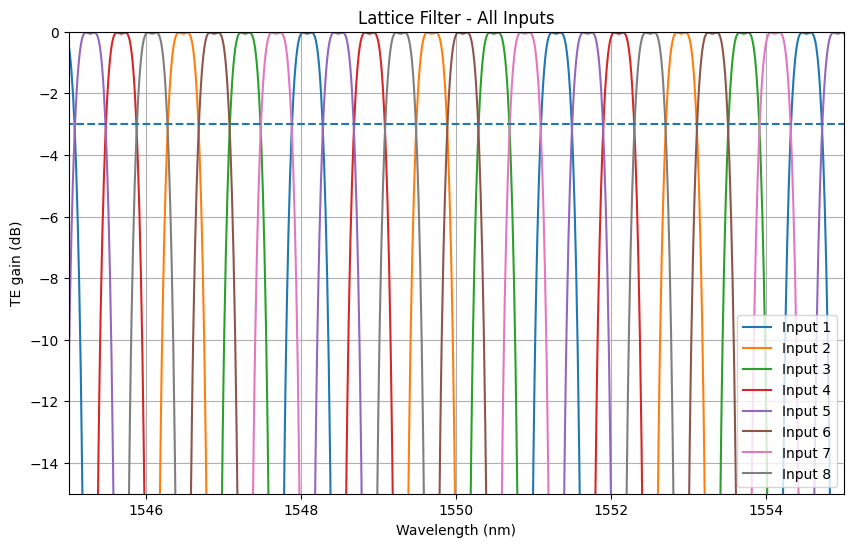

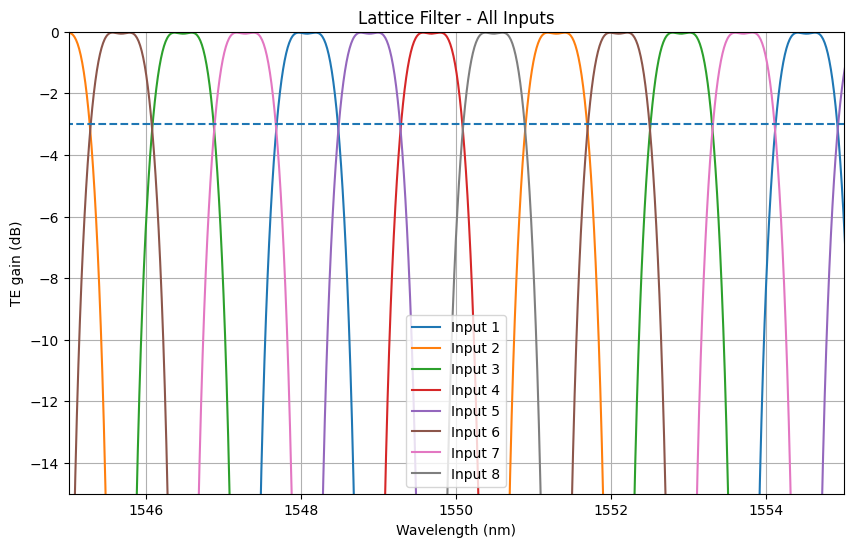

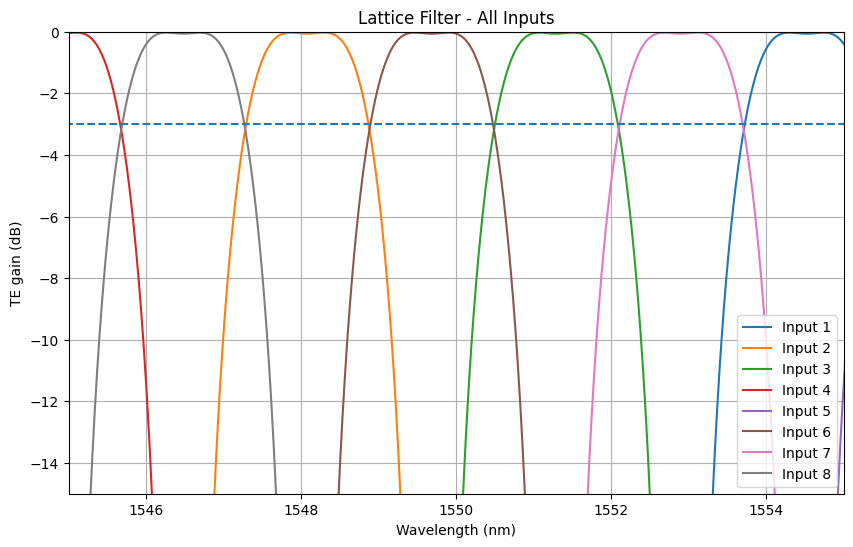

In [59]:
lattice_filter(0.4,'ideal')
lattice_filter(0.8,'ideal')
lattice_filter(1.6,'ideal')

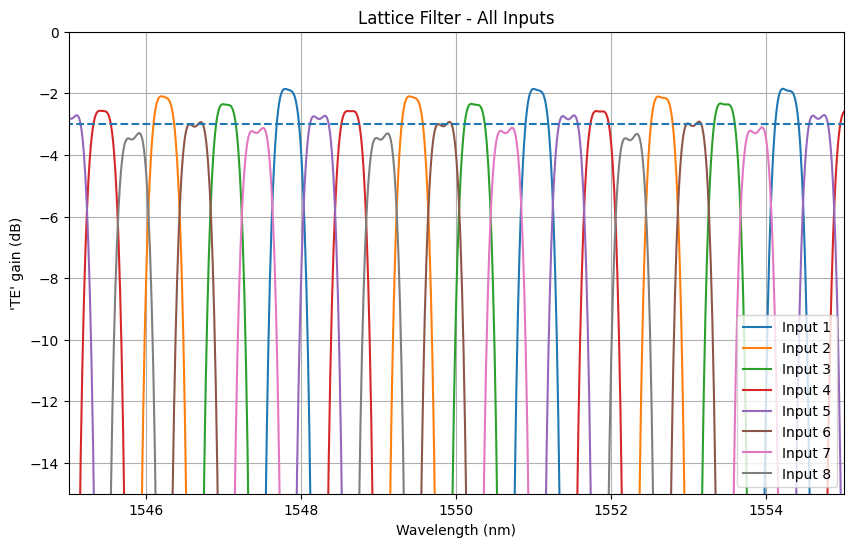

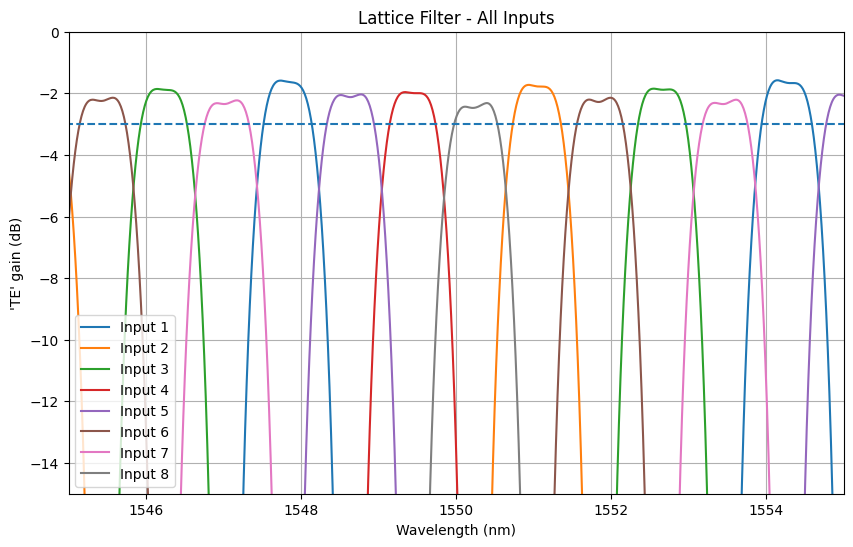

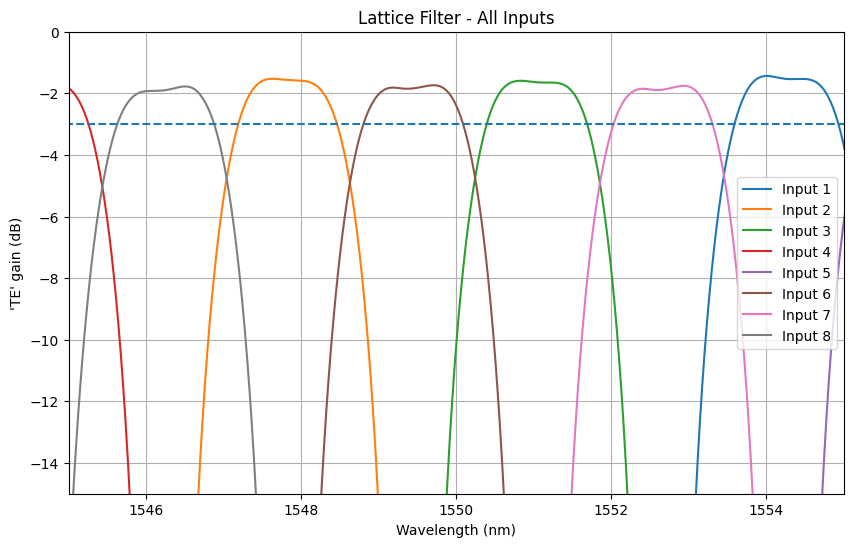

In [63]:
lattice_filter(0.4,'pdk')
lattice_filter(0.8,'pdk')
lattice_filter(1.6,'pdk')

In [11]:
'''
fsr é o valor em nm do fsr
ORDEM é a ordem do filtro usado na cascada (vai de 1 a 3), o número depois se refere a ordem de cada filtro individualmente
cascade é a quantidade de filtros usados naquele nivel podendo ser 1, 2 ou 4
type é se é ideal ou pdk
'''
def MZI_filter_optimized(fsr,ORDEMA,ORDEMB,ORDEMC,ORDEMD,cascade,type,c05,c02,c004,c029,c008):
    
    X = {0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 2, 6: 2}
    Y = {0: 0, 1: -1, 2: 1, 3: -2, 4: -1, 5: 1, 6: 2}
    if (type == "ideal"):
        Coupler = "Waveguide Coupler"
        Straight_Waveguide = "Straight waveguide"
        ng = 4.3458
        neff = 2.3531
        lenght_name = 'length'
        port = 'port '
    if (type == 'pdk'):
        Coupler = "ebeam_dc_te1550"
        Straight_Waveguide = 'ebeam_wg_integral_1550'
        ng = 4.19088
        neff = 2.44553
        lenght_name = 'wg_length'
        port = 'opt_'
    

    
    for n in range (cascade):
        if (cascade==1):
            level='A'
            final_conection1 = f"splitterB{2*n}0"
            fc_input1 = f"{port}2"
            final_conection2 = f"splitterB{2*n+1}0"
            fc_input2 = f"{port}1"
        if (cascade==2):
            level='B'
            final_conection1 = f"splitterC{2*n}0"
            fc_input1 = f"{port}2"
            final_conection2 = f"splitterC{2*n+1}0"
            fc_input2 = f"{port}1"
        if (cascade==4):
            level='C' 
            final_conection1 = "ONA"
            fc_input1 = f"input {2*n+1}"
            final_conection2 = f"ONA"
            fc_input2 = f"input {2*n+2}"       
        x= X[n+cascade-1]
        y= Y[n+cascade-1]
        if n==0: ordem=ORDEMA
        if n==1: ordem=ORDEMB
        if n==2: ordem=ORDEMC
        if n==3: ordem=ORDEMD

        for i in range (ordem):
            
            if ordem==1:
                coupling_length = [c05*um,c05*um]
                power_couplings = [0.5,0.5]
            if ordem==2:
                coupling_length = [c05*um,c029*um,c008*um]
                power_couplings = [0.5,0.29,0.08]
            if ordem==3:
                coupling_length = [c05*um,c02*um,c02*um,c004*um]
                power_couplings = [0.5,0.2,0.2,0.04]
            
            ict_api.addelement(Coupler)
            ict_api.set("name",f"splitter{level}{n}{i}")
            if (type=="pdk"):
                ict_api.set("coupling_length",coupling_length[i])
            if (type=="ideal"):
                ict_api.set("coupling coefficient 1",power_couplings[i])
                ict_api.set("coupling coefficient 2",power_couplings[i])
            ict_api.addelement(Straight_Waveguide)
            ict_api.set("name",f"wvg{level}{n}{i}")
            if (type=="ideal"):
                ict_api.set("effective index 1",neff)
                ict_api.set("group index 1",ng)
            ict_api.set(lenght_name,L+delay_length(-(np.log2(cascade)-3),n,i,fsr,ng,neff))
            ict_api.addelement(Straight_Waveguide)
            ict_api.set("name",f"wvg2{level}{n}{i}")
            if (type=="ideal"):
                ict_api.set("effective index 1",neff)
                ict_api.set("group index 1",ng)
            ict_api.set(lenght_name,L)#delay_length(cascate,horizontal_section,mzi,fsr_ofc,,ng)
            
            xs = -1000 +1400*x + (i*400)
            ys = +1500 + y*(1500/4)
            xc=xs+400
            yc=ys
            xw1=xs+200
            yw1=ys-100
            xw2=xw1
            yw2= ys+100 
            ict_api.setposition(f"splitter{level}{n}{i}",xs,ys)
            ict_api.setposition(f"wvg{level}{n}{i}",xw1,yw1)
            ict_api.setposition(f"wvg2{level}{n}{i}",xw2,yw2)
            
            ict_api.connect(f"splitter{level}{n}{i}", f"{port}3", f"wvg{level}{n}{i}", "port 1")
            ict_api.connect(f"splitter{level}{n}{i}", f"{port}4", f"wvg2{level}{n}{i}", "port 1")
            if i>0:
                ict_api.connect(f"wvg{level}{n}{i-1}", "port 2", f"splitter{level}{n}{i}", f"{port}1")
                ict_api.connect(f"wvg2{level}{n}{i-1}", "port 2", f"splitter{level}{n}{i}", f"{port}2")
                ict_api.select(f"wvg{level}{n}{i}")
                ict_api.set(lenght_name,L)
                ict_api.select(f"wvg2{level}{n}{i}")
                ict_api.set(lenght_name,L+delay_length(-(np.log2(cascade)-3),n,i,fsr,ng,neff))
            if i==(ordem-1):
                ict_api.addelement(Coupler)
                ict_api.set("name",f"combiner{level}{n}{i}")
                ict_api.setposition(f"combiner{level}{n}{i}",xc,yc)   
                if (type=="pdk"):
                    ict_api.set("coupling_length",coupling_length[i+1])
                if (type=="ideal"):
                    ict_api.set("coupling coefficient 1",power_couplings[i+1])
                    ict_api.set("coupling coefficient 2",power_couplings[i+1])
                ict_api.connect(f"wvg{level}{n}{i}", "port 2", f"combiner{level}{n}{i}", f"{port}1")
                ict_api.connect(f"wvg2{level}{n}{i}", "port 2", f"combiner{level}{n}{i}", f"{port}2")
                ict_api.connect(f"combiner{level}{n}{i}", f"{port}3",final_conection1, fc_input1)
                ict_api.connect(f"combiner{level}{n}{i}", f"{port}4",final_conection2, fc_input2)


In [12]:
def lattice_filter_opt(fsr,type,c05,c02,c004,c029,c008):
    ict_api.switchtodesign()

    ict_api.deleteall()

    ict_api.addelement("Optical Network Analyzer")
    ict_api.set("name","ONA")
    ict_api.set("number of points",10000)
    ict_api.set("input parameter",2)
    ict_api.set("start frequency",c/(1500*nm))
    ict_api.set("stop frequency",c/(1600*nm))
    ict_api.setposition("ONA",0,0)
    ict_api.set("number of input ports", 8)

    if (type == "ideal"): TE_gain = "TE gain (dB)" ;port = 'port '
    if (type == "pdk"): TE_gain = "'TE' gain (dB)" ;port = 'opt_'
    
    MZI_filter_optimized(fsr,2,2,2,2,4,type,c05,c02,c004,c029,c008)
    MZI_filter_optimized(fsr,2,2,2,2,2,type,c05,c02,c004,c029,c008)
    MZI_filter_optimized(fsr,2,2,2,2,1,type,c05,c02,c004,c029,c008)
            
        
    ict_api.connect("splitterA00", f"{port}2","ONA", "output")
    
    ict_api.switchtodesign()
    ict_api.run()
        
    plt.figure(figsize=(10,6))  # Tamanho do gráfico

    for input in range(8):
        wavelength = ict_api.getresult("ONA", f"input {input+1}/mode 1/gain")['wavelength']
        te_gain_db = ict_api.getresult("ONA", f"input {input+1}/mode 1/gain")[TE_gain]
        plt.plot(wavelength*1e9, te_gain_db, label=f'Input {input+1}')  # X em nm

    # Configurações atualizadas
    plt.xlabel('Wavelength (nm)')
    plt.ylabel(TE_gain)
    plt.title('Lattice Filter - All Inputs')
    plt.grid(True)
    plt.legend()
    plt.xlim(1545, 1555)  # Novo limite X
    plt.ylim(-15,0)    # Novo limite Y
    plt.hlines(-3, 1530, 1565,linestyles="--")
    plt.show()

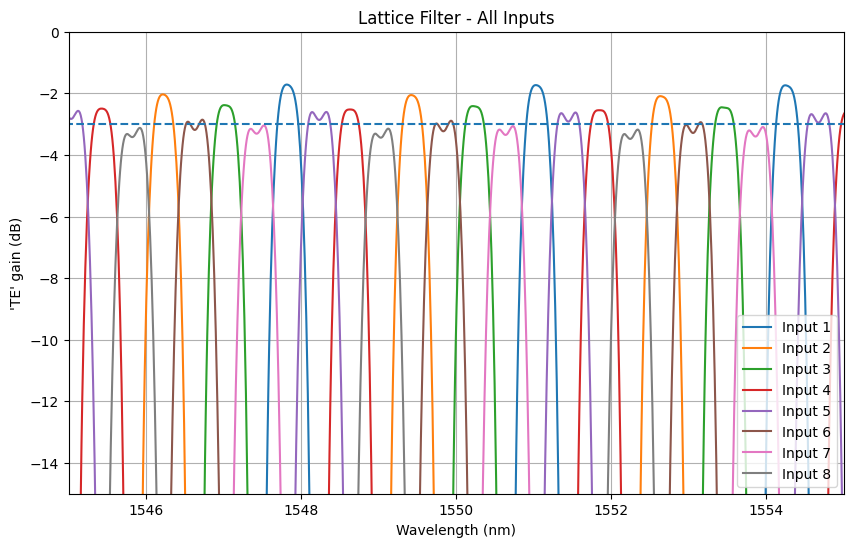

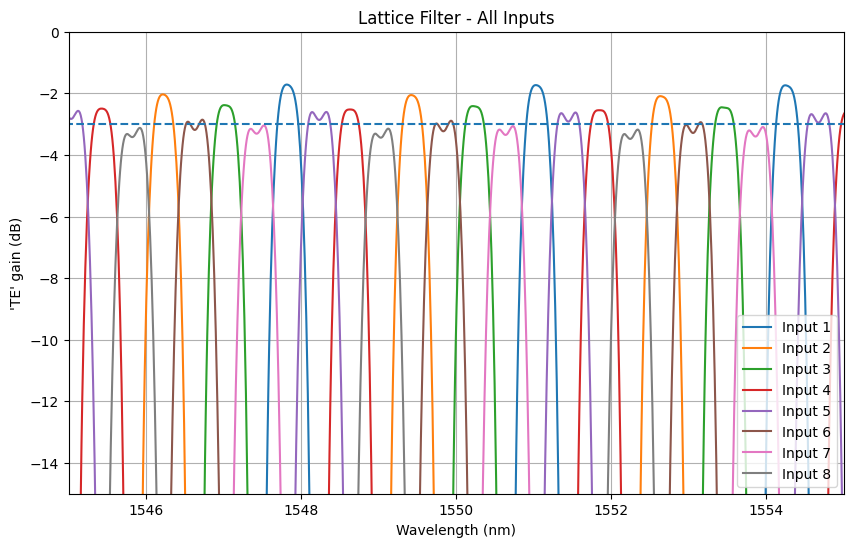

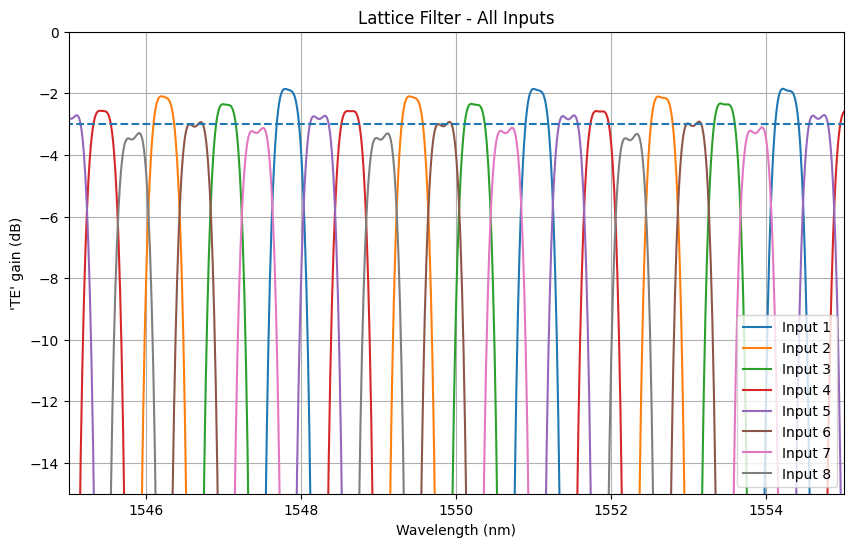

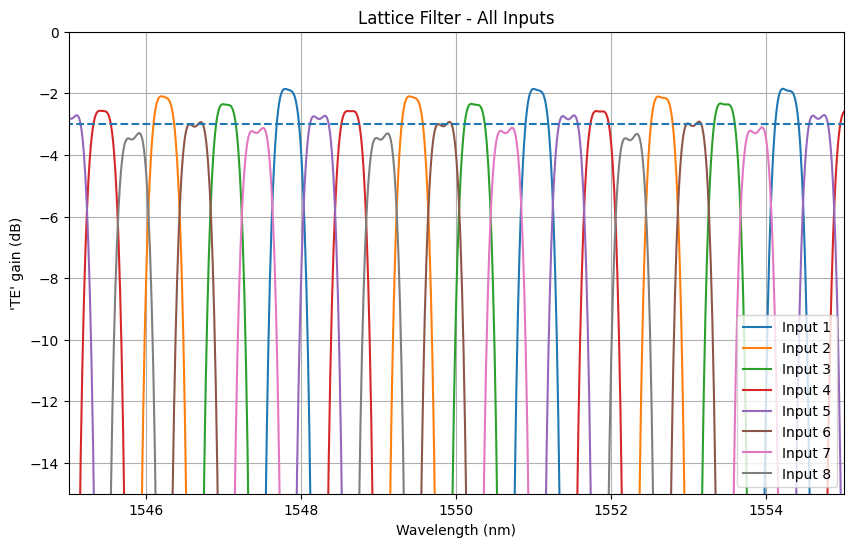

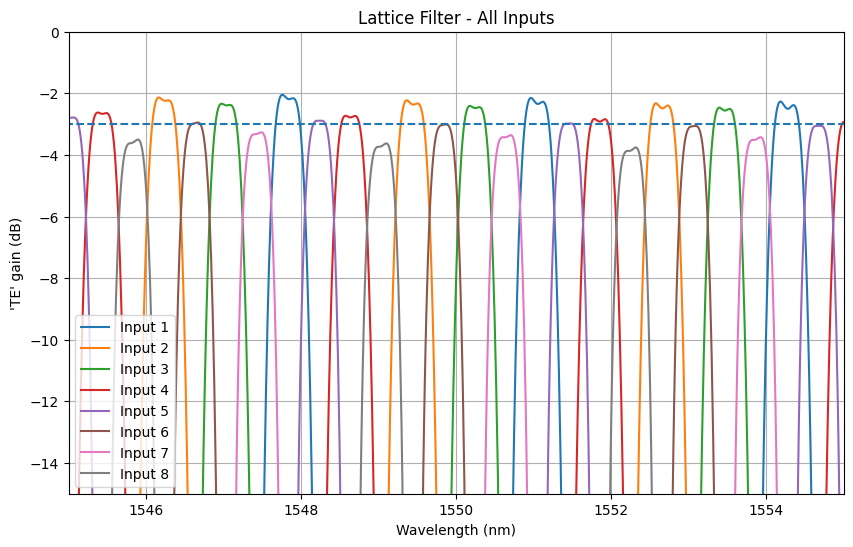

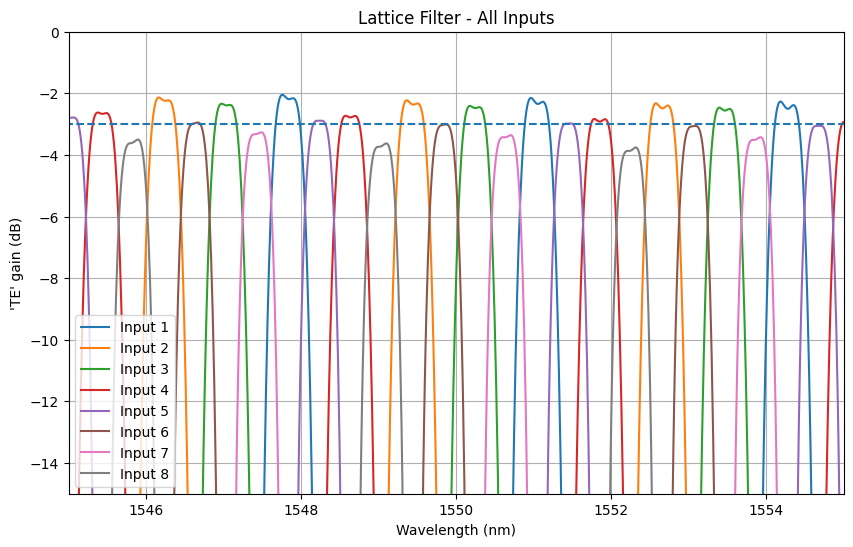

In [18]:
lenght=np.linspace(15,20,6)

for i in range(6):
    lattice_filter_opt(0.4,'pdk',lenght[i],10,2.5,12.5,5)

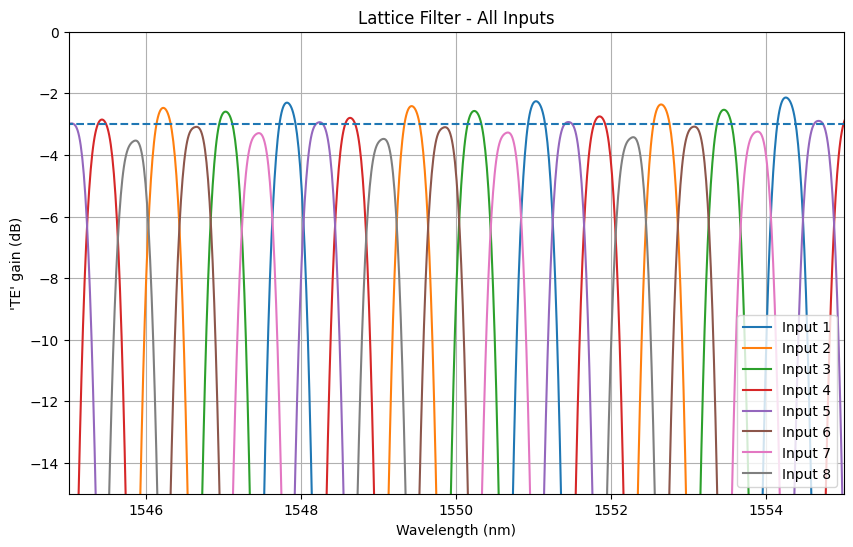

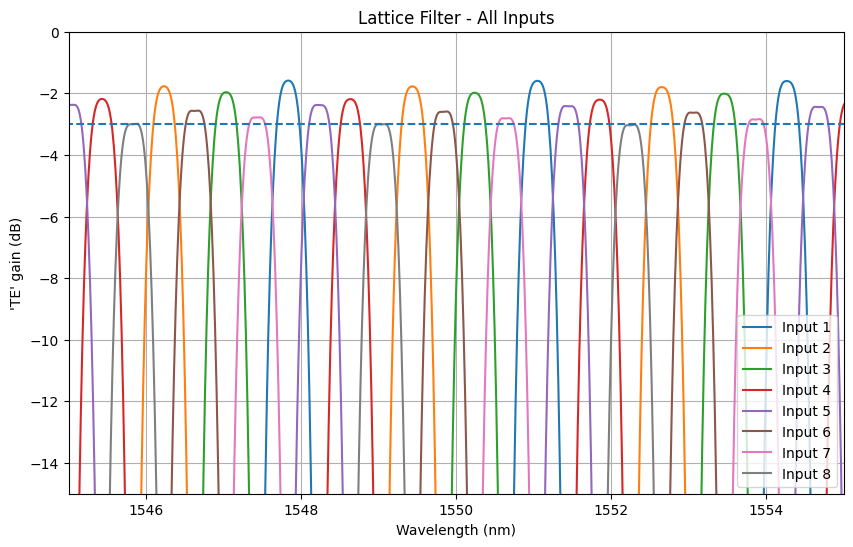

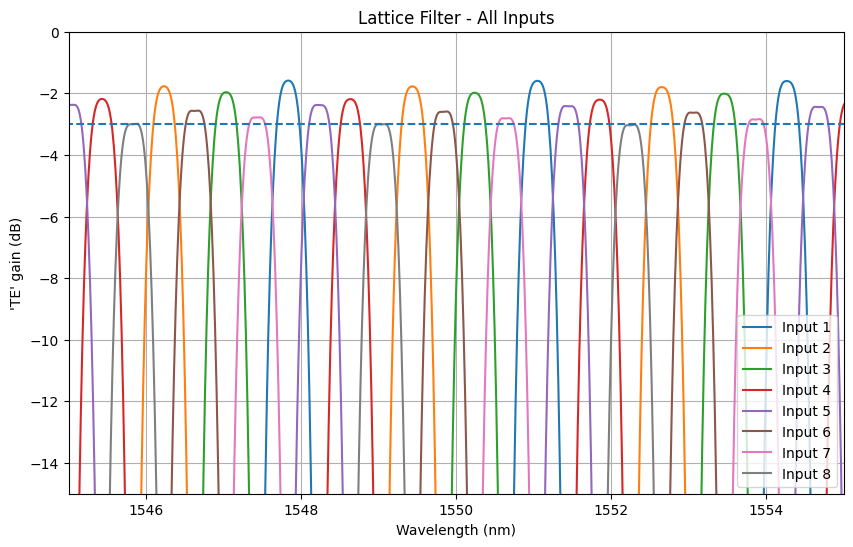

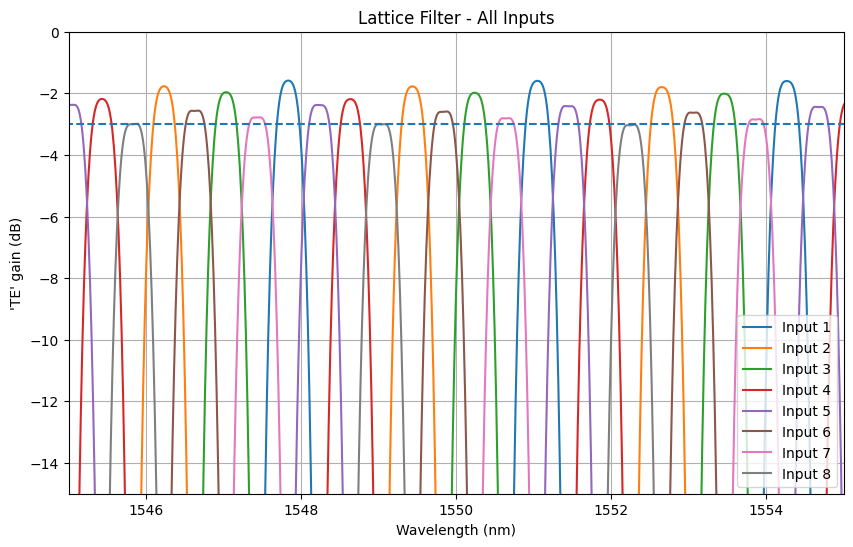

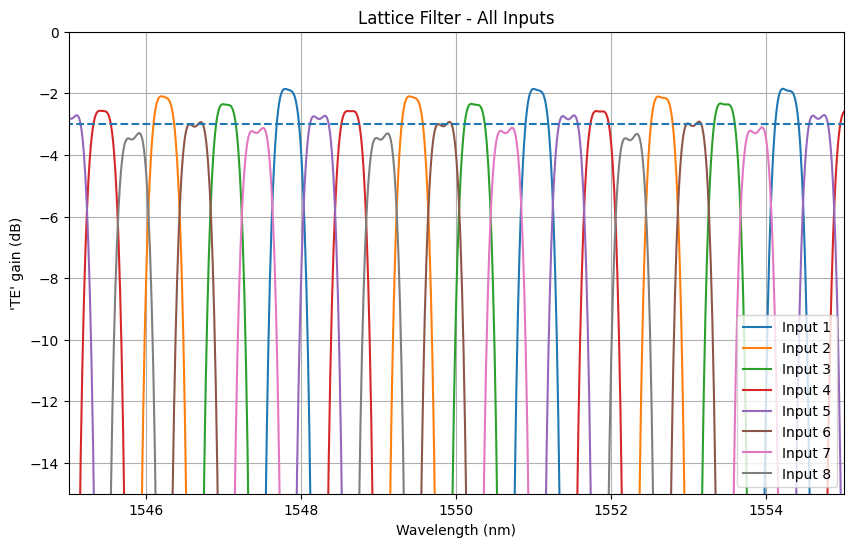

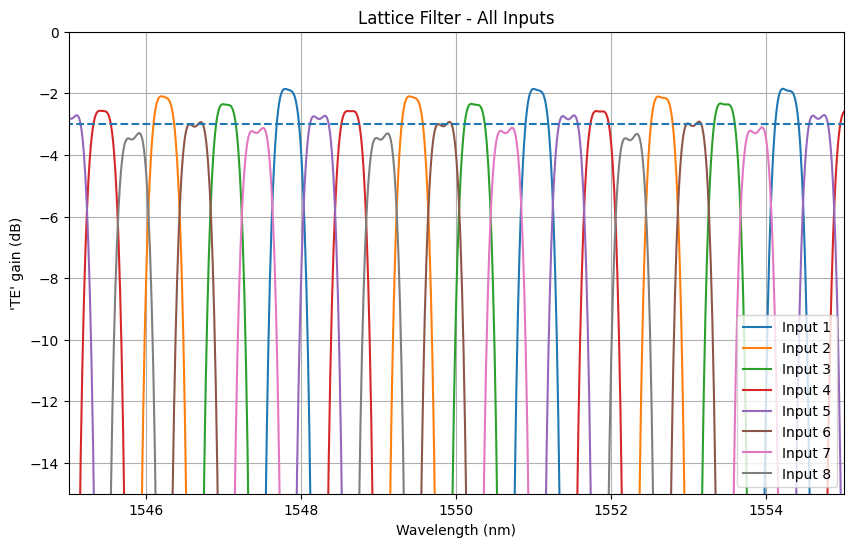

In [21]:
lenght=np.linspace(8,13,6)

for i in range(6):
    lattice_filter_opt(0.4,'pdk',17,10,2.5,lenght[i],5)

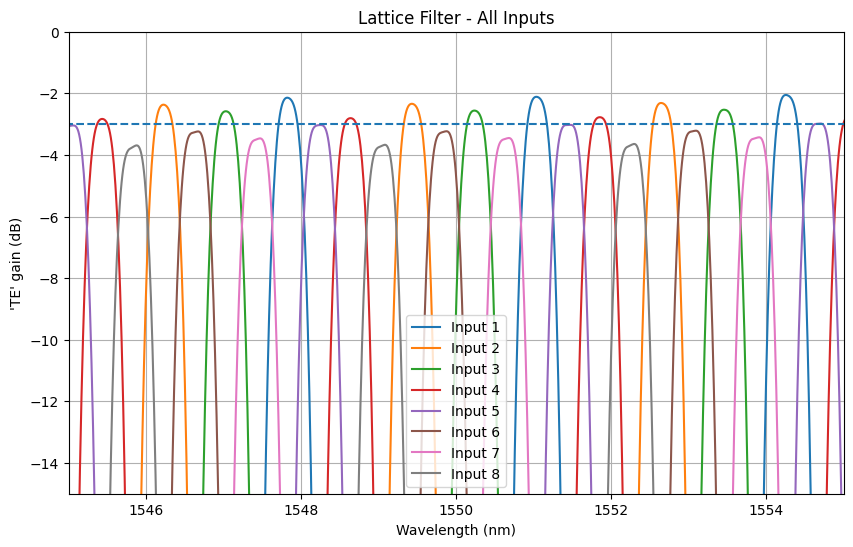

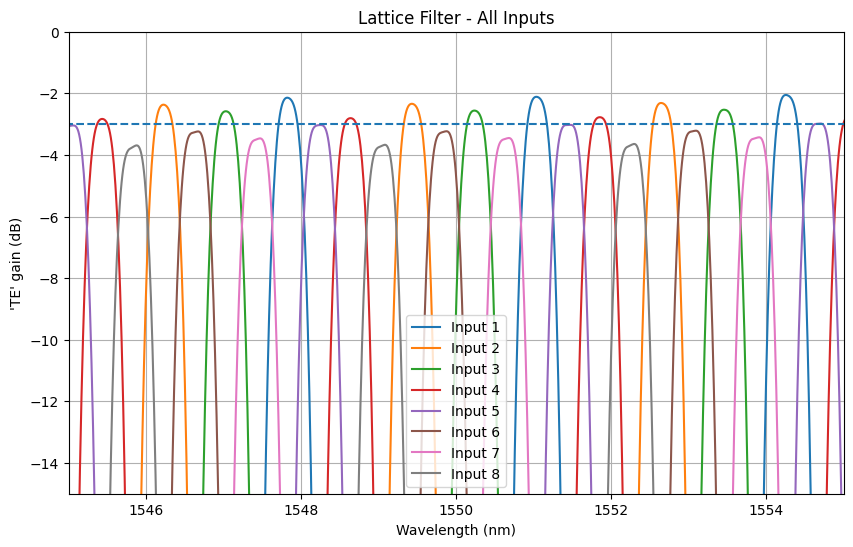

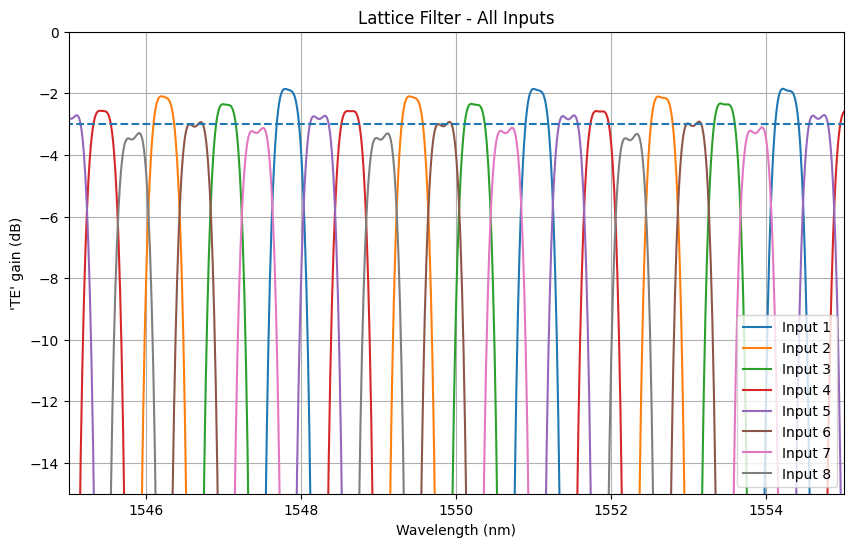

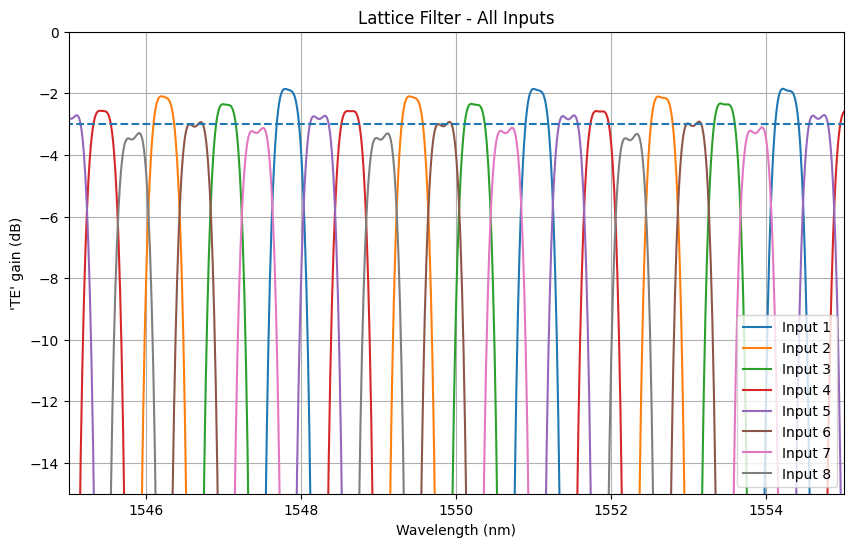

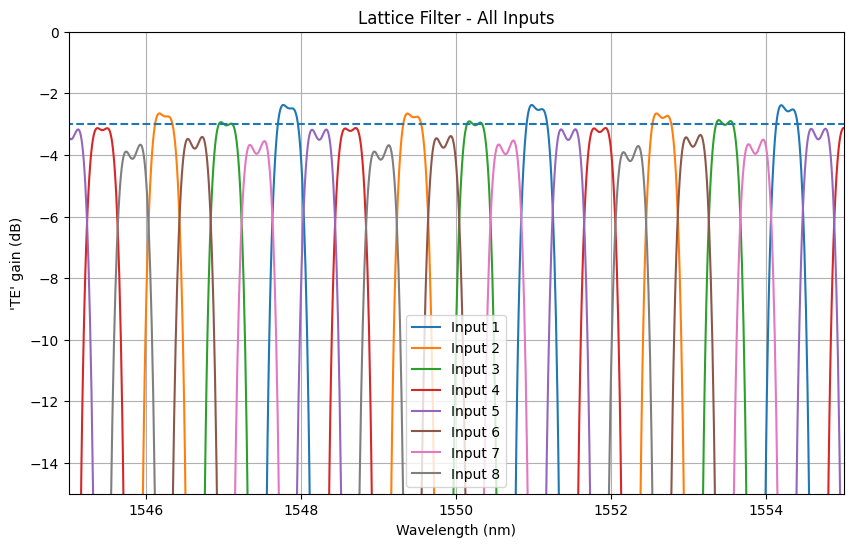

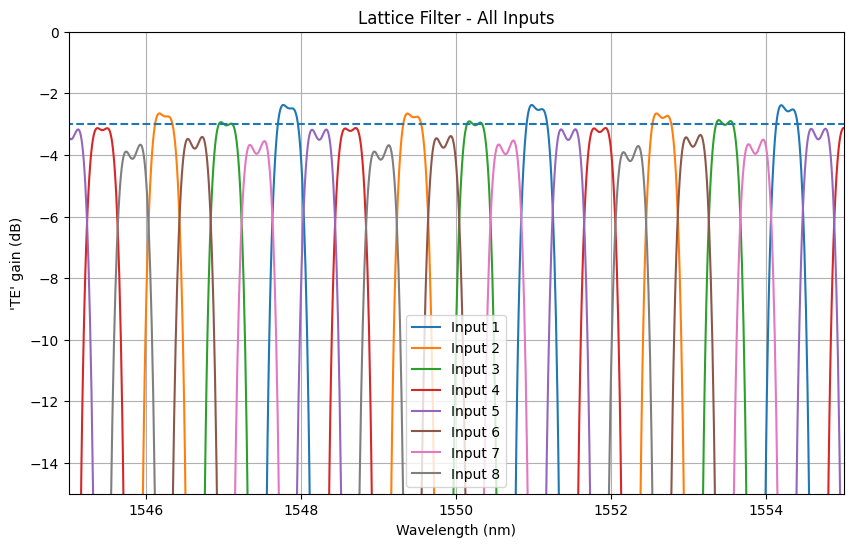

In [20]:
lenght=np.linspace(2.5,7.5,6)

for i in range(6):
    lattice_filter_opt(0.4,'pdk',17.5,10,2.5,12.5,lenght[i])

In [14]:
def lattice_filter_order(fsr,type):
    ict_api.switchtodesign()

    ict_api.deleteall()

    ict_api.addelement("Optical Network Analyzer")
    ict_api.set("name","ONA")
    ict_api.set("number of points",10000)
    ict_api.set("input parameter",2)
    ict_api.set("start frequency",c/(1500*nm))
    ict_api.set("stop frequency",c/(1600*nm))
    ict_api.setposition("ONA",0,0)
    ict_api.set("number of input ports", 8)

    if (type == "ideal"): TE_gain = "TE gain (dB)" ;port = 'port '
    if (type == "pdk"): TE_gain = "'TE' gain (dB)" ;port = 'opt_'
    
    MZI_filter_optimized(fsr,2,1,1,1,4,type,17.5,10,2.5,10,5)
    MZI_filter_optimized(fsr,2,1,0,0,2,type,17.5,10,2.5,10,5)
    MZI_filter_optimized(fsr,2,0,0,0,1,type,17.5,10,2.5,10,5)
            
        
    ict_api.connect("splitterA00", f"{port}2","ONA", "output")
    
    ict_api.switchtodesign()
    ict_api.run()
        
    plt.figure(figsize=(10,6))  # Tamanho do gráfico

    for input in range(8):
        wavelength = ict_api.getresult("ONA", f"input {input+1}/mode 1/gain")['wavelength']
        te_gain_db = ict_api.getresult("ONA", f"input {input+1}/mode 1/gain")[TE_gain]
        plt.plot(wavelength*1e9, te_gain_db, label=f'Input {input+1}')  # X em nm

    # Configurações atualizadas
    plt.xlabel('Wavelength (nm)')
    plt.ylabel(TE_gain)
    plt.title('Lattice Filter - All Inputs')
    plt.grid(True)
    plt.legend()
    plt.xlim(1545, 1555)  # Novo limite X
    plt.ylim(-15,0)    # Novo limite Y
    plt.hlines(-3, 1530, 1565,linestyles="--",)
    plt.show()

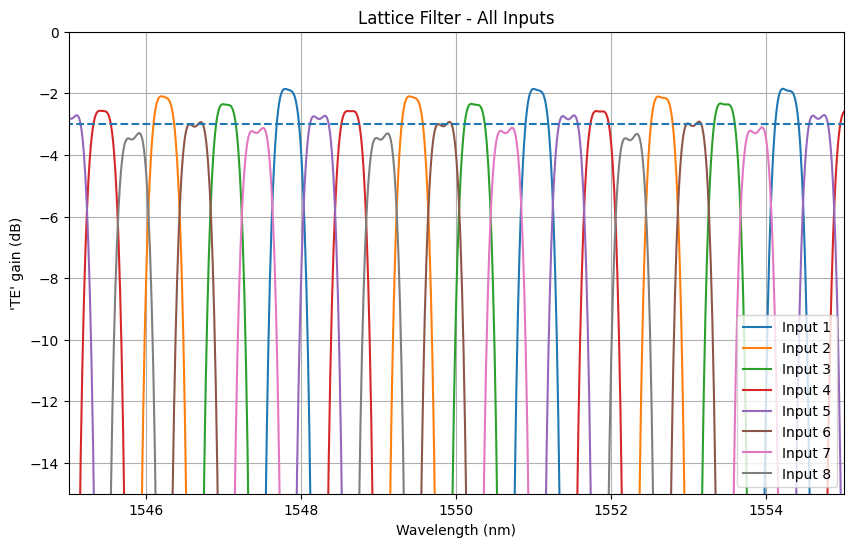

In [24]:
lattice_filter(0.4,'pdk')

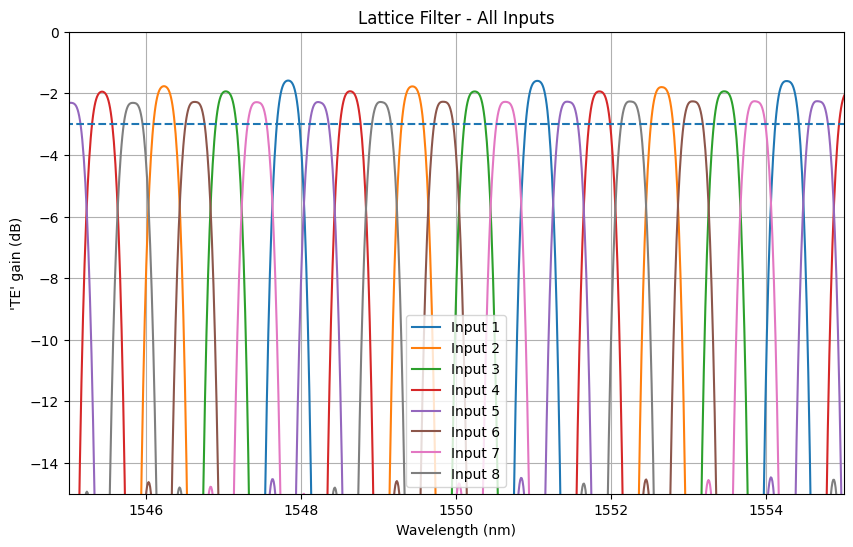

In [26]:
lattice_filter_order(0.4,'pdk')

In [48]:
def montecarlo(ORDEM1,ORDEM21,ORDEM22,ORDEM31,ORDEM32,ORDEM33,ORDEM34):

    sweep_name = "Monte Carlo analysis"
    nop=10
    ict_api.deletesweep(sweep_name)
    ict_api.addsweep(2)
    ict_api.setsweep('sweep','name',sweep_name)
    ict_api.setsweep(sweep_name, "Number of trials", nop)
    ict_api.setsweep(sweep_name, "Batch size", nop)

    for n in range (1):           
        if n==0: ordem=ORDEM31
        if n==1: ordem=ORDEM32
        if n==2: ordem=ORDEM33
        if n==3: ordem=ORDEM34
        for i in range (ordem):
            
            if ordem==1: coupling_length = [17.5*um,17.5*um]
            if ordem==2: coupling_length = [17.5*um,10*um,5*um]
            if ordem==3: coupling_length = [17.5*um,10*um,10*um,2.5*um]
            
            para = {}
            para['Name']= f"splitterC{n}{i}"
            para['Parameter']= f"::Root Element::splitterC{n}{i}::coupling_length"
            para['Value']= (coupling_length[i])
            para["Distribution"]= {"type": "gaussian","variation": 0.02*(coupling_length[i])}
            ict_api.addsweepparameter(sweep_name,para) 
            
            if i==(ordem-1):
                para = {}
                para['Name']= f"combinerC{n}{i}"
                para['Parameter']= f"::Root Element::combinerC{n}{i}::coupling_length"
                para['Value']= (coupling_length[i+1])
                para["Distribution"]= {"type": "gaussian","variation": 0.02*(coupling_length[i+1])}
                ict_api.addsweepparameter(sweep_name,para) 
                
                  
    for n in range (2):

        if n==0: ordem=ORDEM21
        if n==1: ordem=ORDEM22
        for i in range (ordem):
            
            if ordem==1: coupling_length = [17.5*um,17.5*um]
            if ordem==2: coupling_length = [17.5*um,10*um,5*um]
            if ordem==3: coupling_length = [17.5*um,10*um,10*um,2.5*um]
            
            para = {}
            para['Name']= f"splitterB{n}{i}"
            para['Parameter']= f"::Root Element::splitterB{n}{i}::coupling_length"
            para['Value']= (coupling_length[i+1])
            para["Distribution"]= {"type": "gaussian","variation": 0.02*(coupling_length[i+1])}
            ict_api.addsweepparameter(sweep_name,para)          

            if i==(ordem-1):
                para = {}
                para['Name']= f"combinerB{n}{i}"
                para['Parameter']= f"::Root Element::combinerB{n}{i}::coupling_length"
                para['Value']= (coupling_length[i+1])
                para["Distribution"]= {"type": "gaussian","variation": 0.02*(coupling_length[i+1])}
                ict_api.addsweepparameter(sweep_name,para)    
                

                
                

    
    for i in range (ORDEM1):
            
        if ORDEM1==1: coupling_length = [17.5*um,17.5*um]
        if ORDEM1==2: coupling_length = [17.5*um,10*um,5*um]
        if ORDEM1==3: coupling_length = [17.5*um,10*um,10*um,2.5*um]
        para = {}
        para['Name']= f"splitterA0{i}"
        para['Parameter']= f"::Root Element::splitterA0{i}::coupling_length"
        para['Value']= (coupling_length[i+1])
        para["Distribution"]= {"type": "gaussian","variation": 0.02*(coupling_length[i+1])}
        ict_api.addsweepparameter(sweep_name,para)
        if i==(ORDEM1-1):
            para = {}
            para['Name']= f"combinerA0{i}"
            para['Parameter']= f"::Root Element::combinerA0{i}::coupling_length"
            para['Value']= (coupling_length[i+1])
            para["Distribution"]= {"type": "gaussian","variation": 0.02*(coupling_length[i+1])}
            ict_api.addsweepparameter(sweep_name,para)


    for i in range (8):
        resu = {}
        resu['Name']= f"input{i+1}"
        resu['Result']= f"::Root Element::ONA::input {i+1}/mode 1/gain"
        ict_api.addsweepresult(sweep_name,resu)         


montecarlo(2,2,1,2,1,1,1)

In [28]:
def montecarlo(fsr,ORDEM1,ORDEM21,ORDEM22,ORDEM31,ORDEM32,ORDEM33,ORDEM34):

    ng=4.19088
    neff=2.44553
    sweep_name = "Monte Carlo analysis"
    nop=100
    ict_api.deletesweep(sweep_name)
    ict_api.addsweep(2)
    ict_api.setsweep('sweep','name',sweep_name)
    ict_api.setsweep(sweep_name, "Number of trials", nop)
    ict_api.setsweep(sweep_name, "Batch size", nop)

    for n in range (4):           
        if n==0: ordem=ORDEM31
        if n==1: ordem=ORDEM32
        if n==2: ordem=ORDEM33
        if n==3: ordem=ORDEM34
        for i in range (ordem):
            
            if i==0: 
                para = {}
                para['Name']= f"wvgC{n}{i}"
                para['Parameter']= f"::Root Element::wvgC{n}{i}::wg_length"
                para['Value']= (L+delay_length(0,n,i,fsr,ng,neff))
                para["Distribution"]= {"type": "gaussian","variation": 0.001*(L+delay_length(0,n,i,fsr,ng,neff))}
                ict_api.addsweepparameter(sweep_name,para) 
                
                para = {}
                para['Name']= f"wvg2C{n}{i}"
                para['Parameter']= f"::Root Element::wvg2C{n}{i}::wg_length"
                para['Value']= (L)
                para["Distribution"]= {"type": "gaussian","variation": 0.001*(L)}
                ict_api.addsweepparameter(sweep_name,para) 
            
            if i>0:
                para = {}
                para['Name']= f"wvgC{n}{i}"
                para['Parameter']= f"::Root Element::wvgC{n}{i}::wg_length"
                para['Value']= (L)
                para["Distribution"]= {"type": "gaussian","variation": 0.001*(L)}
                ict_api.addsweepparameter(sweep_name,para) 
                
                para = {}
                para['Name']= f"wvg2C{n}{i}"
                para['Parameter']= f"::Root Element::wvg2C{n}{i}::wg_length"
                para['Value']= (L+delay_length(0,n,i,fsr,ng,neff))
                para["Distribution"]= {"type": "gaussian","variation": 0.001*(L+delay_length(0,n,i,fsr,ng,neff))}
                ict_api.addsweepparameter(sweep_name,para) 
                
                  
    for n in range (2):

        if n==0: ordem=ORDEM21
        if n==1: ordem=ORDEM22
        for i in range (ordem):
            
            if i==0: 
                para = {}
                para['Name']= f"wvgB{n}{i}"
                para['Parameter']= f"::Root Element::wvgB{n}{i}::wg_length"
                para['Value']= (L+delay_length(1,n,i,fsr,ng,neff))
                para["Distribution"]= {"type": "gaussian","variation": 0.001*(L+delay_length(1,n,i,fsr,ng,neff))}
                ict_api.addsweepparameter(sweep_name,para) 
                
                para = {}
                para['Name']= f"wvg2B{n}{i}"
                para['Parameter']= f"::Root Element::wvg2B{n}{i}::wg_length"
                para['Value']= (L)
                para["Distribution"]= {"type": "gaussian","variation": 0.001*(L)}
                ict_api.addsweepparameter(sweep_name,para) 
            
            if i>0:
                para = {}
                para['Name']= f"wvgB{n}{i}"
                para['Parameter']= f"::Root Element::wvgB{n}{i}::wg_length"
                para['Value']= (L)
                para["Distribution"]= {"type": "gaussian","variation": 0.001*(L)}
                ict_api.addsweepparameter(sweep_name,para) 
                
                para = {}
                para['Name']= f"wvg2B{n}{i}"
                para['Parameter']= f"::Root Element::wvg2B{n}{i}::wg_length"
                para['Value']= (L+delay_length(1,n,i,fsr,ng,neff))
                para["Distribution"]= {"type": "gaussian","variation": 0.001*(L+delay_length(1,n,i,fsr,ng,neff))}
                ict_api.addsweepparameter(sweep_name,para)    
                

                
                

    
    for i in range (ORDEM1):
            
        if i==0: 
            para = {}
            para['Name']= f"wvgA0{i}"
            para['Parameter']= f"::Root Element::wvgA0{i}::wg_length"
            para['Value']= (L+delay_length(2,n,i,fsr,ng,neff))
            para["Distribution"]= {"type": "gaussian","variation": 0.001*(L+delay_length(2,n,i,fsr,ng,neff))}
            ict_api.addsweepparameter(sweep_name,para) 
            
            para = {}
            para['Name']= f"wvg2A0{i}"
            para['Parameter']= f"::Root Element::wvg2A0{i}::wg_length"
            para['Value']= (L)
            para["Distribution"]= {"type": "gaussian","variation": 0.001*(L)}
            ict_api.addsweepparameter(sweep_name,para) 
        
        if i>0:
            para = {}
            para['Name']= f"wvgA0{i}"
            para['Parameter']= f"::Root Element::wvgA0{i}::wg_length"
            para['Value']= (L)
            para["Distribution"]= {"type": "gaussian","variation": 0.001*(L)}
            ict_api.addsweepparameter(sweep_name,para) 
            
            para = {}
            para['Name']= f"wvg2A0{i}"
            para['Parameter']= f"::Root Element::wvg2A0{i}::wg_length"
            para['Value']= (L+delay_length(2,n,i,fsr,ng,neff))
            para["Distribution"]= {"type": "gaussian","variation": 0.001*(L+delay_length(2,n,i,fsr,ng,neff))}
            ict_api.addsweepparameter(sweep_name,para)    
            


    for i in range (8):
        resu = {}
        resu['Name']= f"input{i+1}"
        resu['Result']= f"::Root Element::ONA::input {i+1}/mode 1/gain"
        ict_api.addsweepresult(sweep_name,resu)         


montecarlo(0.4,2,2,1,2,1,1,1)

In [20]:
ict_api.save("teste da otimizacao")

In [37]:
ict_api.runsweep("Monte Carlo analysis")

In [46]:

T_data = np.abs(ict_api.getsweepdata("Monte Carlo analysis", 'input1'))
np.shape(T_data)

(10000, 100)

In [33]:
print(T_data)

[[ 4.1648094  25.46102123  4.03121819 ...  8.47272557  3.38452555
   3.9852385 ]
 [ 4.18360083 25.22691055  4.08060603 ...  8.75600714  3.34603288
   3.99644339]
 [ 4.20835716 24.97706283  4.1345226  ...  9.05869442  3.31880697
   4.00699573]
 ...
 [14.53647547  9.76908462 13.92565935 ... 16.99691186 22.53143505
  27.66091533]
 [14.70938295  9.63048043 14.03141986 ... 17.12574445 22.69511762
  28.23927716]
 [14.88810116  9.50000142 14.13758915 ... 17.24448072 22.86177058
  28.82663114]]


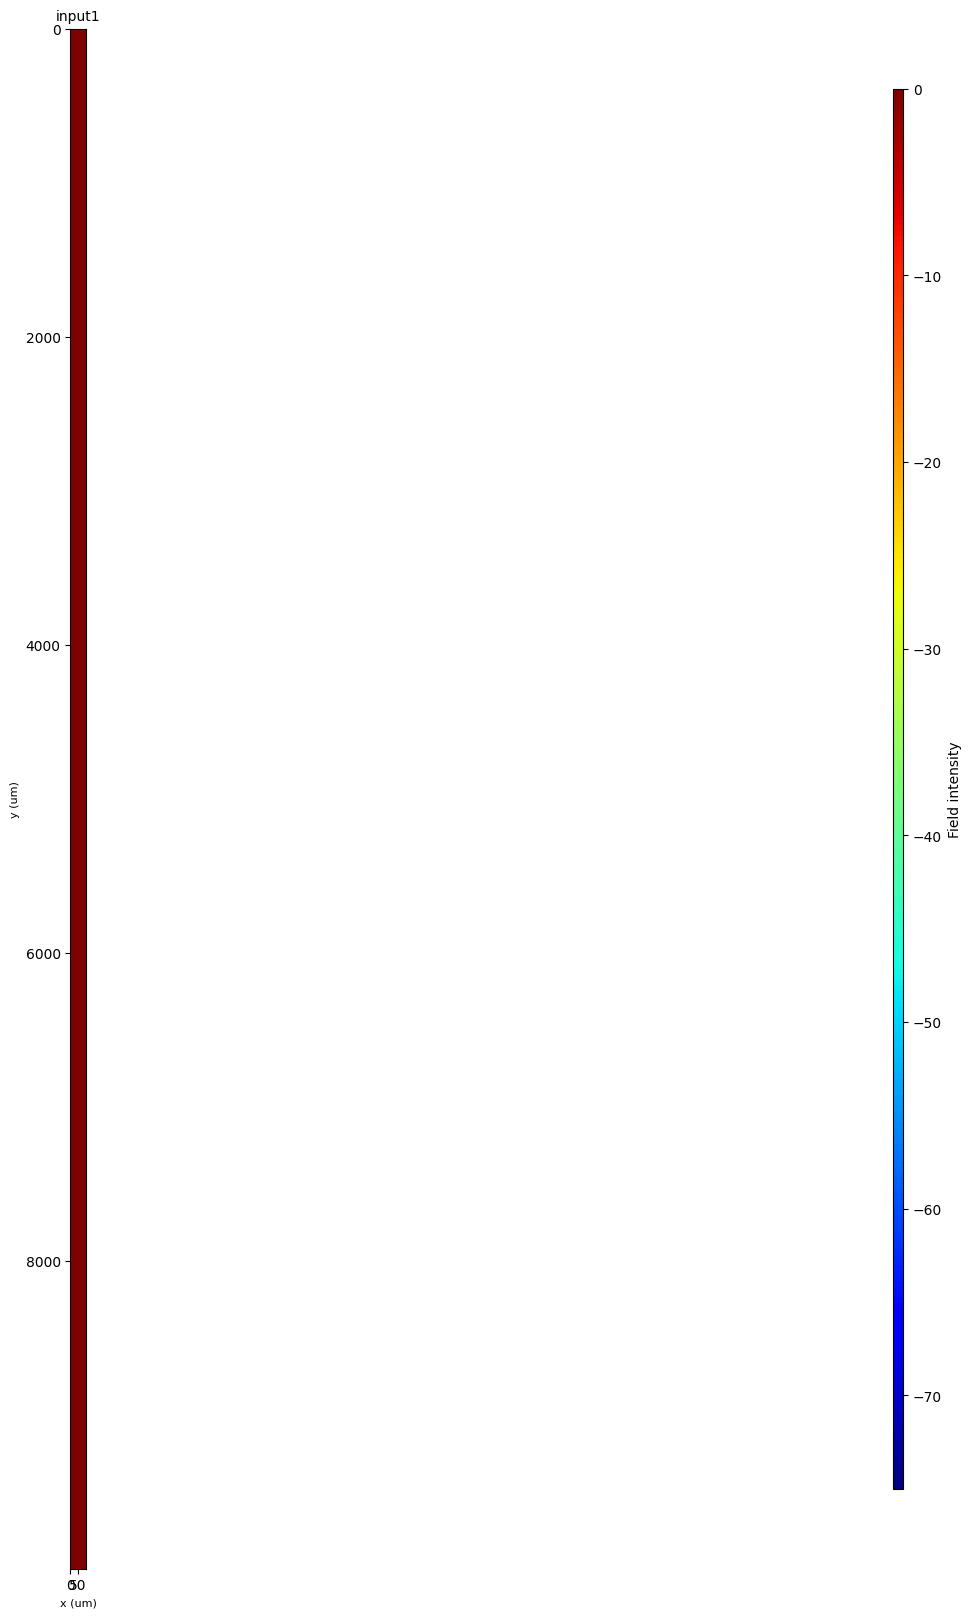

In [ ]:
fig, axs = 
plt.subplots(1, 1, figsize=(20,20) )

im = plt.imshow(T_data, cmap='jet', vmin=-75, vmax=0.001)

plt.title('input1', fontsize=10)
plt.xlabel('x (um)', fontsize=8)
plt.ylabel('y (um)', fontsize=8)

cbar_ax = fig.add_axes([0.92, 0.15, 0.005, 0.7])  # [x, y, largura, altura]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Field intensity')
plt.show()

plt.figure(figsize=(10, 8))
plt.imshow(T_data, cmap='jet', norm=colors.LogNorm(vmin=0.001, vmax=1),extent=[-5, 5, -5, 5])

# Adding colorbar
cbar = plt.colorbar(label='Perda em log')
tick_locations = [0.001, 0.00316, 0.01, 0.0316, 0.1, 0.316, 1]
tick_labels = ['0.001', '0.00316', '0.01', '0.0316', '0.1', '0.316', '1']
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

# Ading title and labels
plt.title(f'etch depth :{etch_depths[i]} nm | lambda = 1550 nm')
plt.xlabel('x')
plt.ylabel('y')

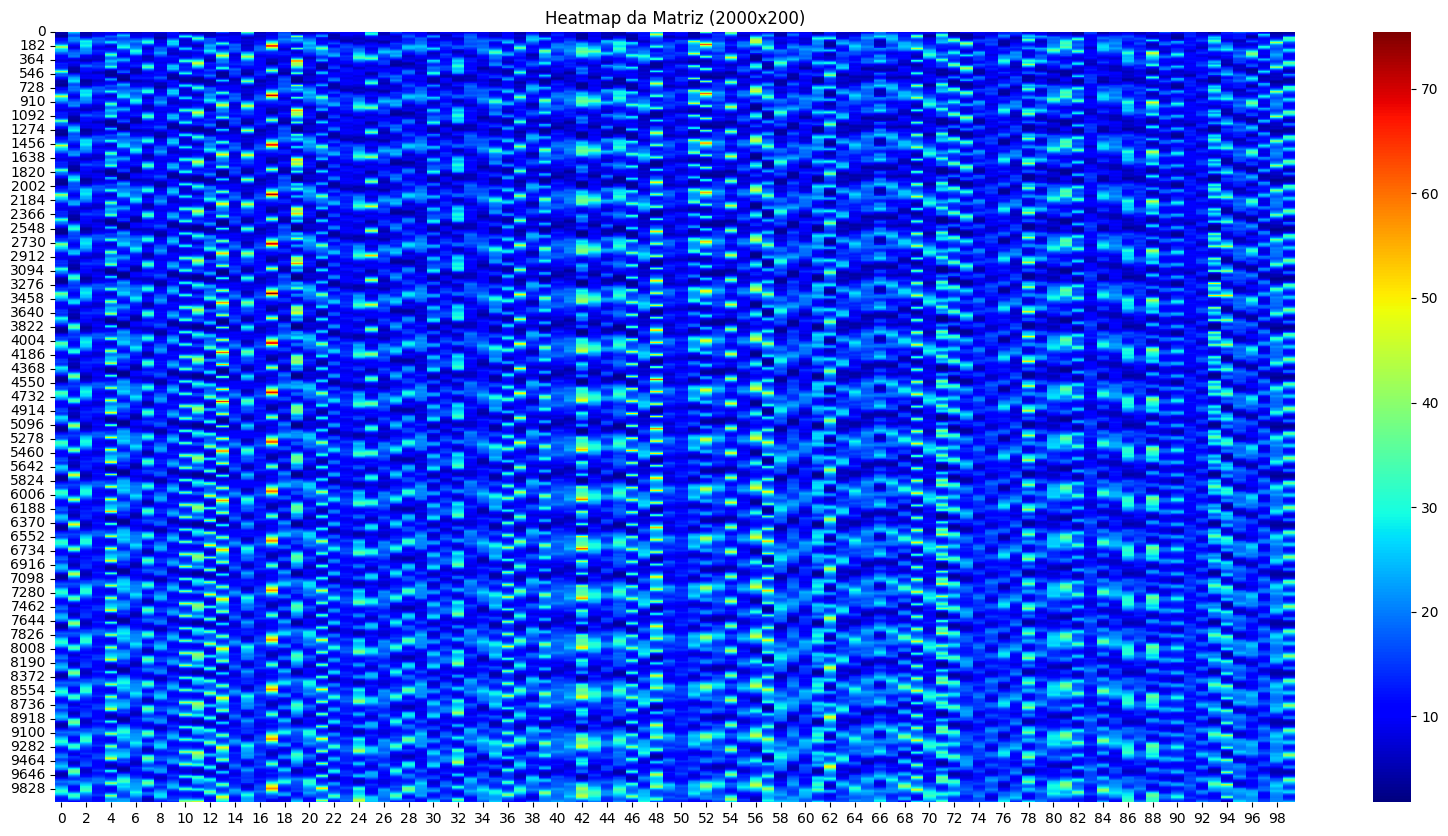

In [39]:
plt.figure(figsize=(20, 10))  # Ajuste o tamanho conforme necessário
sns.heatmap(T_data, cmap="jet")
plt.title("Heatmap da Matriz (2000x200)")
plt.show()